# Example Case of DUKF

Author: Seongchun Yang

Affiliation: Kyoto University

In [3]:
import numpy as np
import scipy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from itertools import product
import sys; sys.path.append('./')

## simulate data

We simulate a case where one state variable is affected by a parameter in transition while the other state is not.
    
$ x_{1,t} = \alpha_t \times x_{1,t-1} $

$ x_{2,t} \approx x_{2,t-1} $

The observation is a product of these two states and one of the states.

$ y_{1,t} = x_{1,t} \times x_{2,t} $

$ y_{2,t} = x_{2,t} $


If we were to filter the variables while estimating the parameters, we require a quite complex method in which that can factorize the data into all variables simultaneously. This is why Dual Extended Kalamn filter reared its head. While having been around for longer, it does require analytical input of Jacobian. Thus, here we are with Dual Unscented Kalman filter.

P.S. (If you are looking at this and thinking, "wow, what a nightmarish solution to a problem that may have an easier solution", well, that was my data when I worked on this code.)

NameError: name 'ax3' is not defined

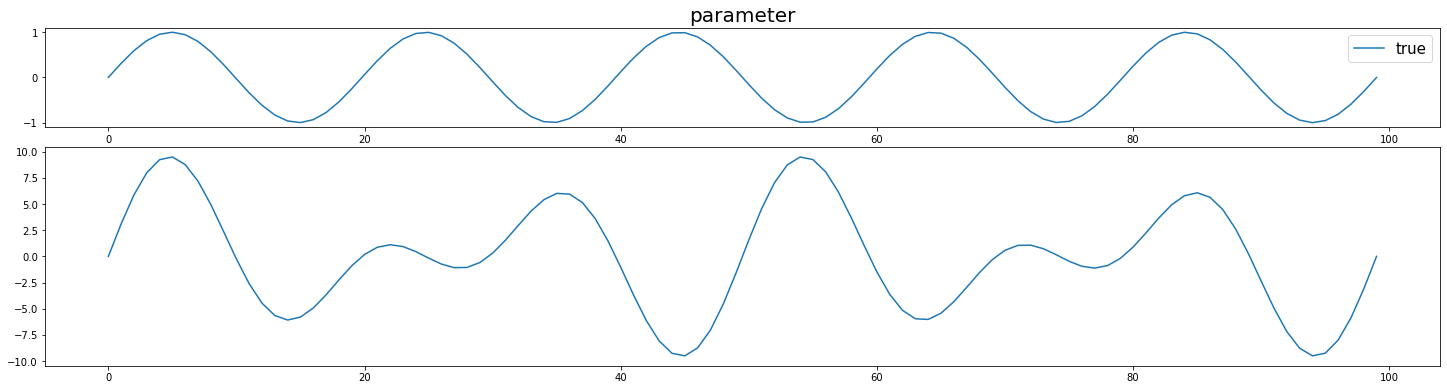

In [4]:
n = 100
noise_var = 0.5
# parameter
p = np.sin(np.linspace(0,10*np.pi,n))
# clean state
x1_pure = np.cos(np.linspace(0,2*np.pi,n)) * 10
x1_clean = np.multiply(x1_pure,p)
x2_clean = np.ones(n) * 3
# observation 1: non-linear (multiplicative) relationship between x1,x2, with uncorrelated white-noise.
y_clean = np.multiply(x1_clean,x2_clean)
y_noisy = np.array([np.random.normal(i,np.sqrt(noise_var),1) for i in y_clean])
# observation 2: noisy state: x2 considered to come from a noisy sensor, thus added with uncorrelated white-noise.
#x2_noisy = np.array([np.random.normal(i,np.sqrt(noise_var),1) for i in x2_clean])
x1_noisy = np.array([np.random.normal(i,np.sqrt(noise_var),1) for i in x1_clean])

fig=plt.figure(figsize=(25,15))
grid=gridspec.GridSpec(nrows=7,ncols=1,figure=fig)

ax1=fig.add_subplot(grid[0,0])
ax1.plot(p,label='true')
ax1.legend(loc = 'upper right',fontsize=15)
ax1.set_title('parameter',size=20)

ax2=fig.add_subplot(grid[1:3,0])
ax2.plot(x1_clean,label='clean')
ax3.plot(x1_noisy,label='noisy')
ax2.legend(loc = 'upper right',fontsize=15)
ax2.set_title('state1'+r'$(x_1)$',size=20)

ax3=fig.add_subplot(grid[3:5,0])
ax3.plot(x2_clean,label='true')
ax3.legend(loc = 'upper right',fontsize=15)
ax3.set_title('state2'+r'$(x_2)$' + ' and an observation' + r'$(y_1)$',size=20)

ax4=fig.add_subplot(grid[5:7,0])
ax4.plot(y_clean,label='clean')
ax4.plot(y_noisy,label='noisy')
ax4.legend(loc = 'upper right',fontsize=15)
ax4.set_title('observation'+r'$(y_2)$',size=20)
fig.tight_layout()

# package data
state_noisy = np.array([x1_clean.ravel(),x2_noisy.ravel()])
obs_noisy = np.array([y_noisy.ravel(),x1_noisy.ravel()])
print(obs_noisy.shape)

# UKF

In [218]:
from KF.DUKF import DualUKF
from filterpy.kalman import MerweScaledSigmaPoints

In [245]:
# initialize object
# initial conditions are not built in s.t. the user can decide to either;
# case[1] : directly use z0,P0 as previous updated z0,P0
# case[2] : use z0,P0 as the current time prediction of state
# Here, case[1] is being used.
DUKF = DualUKF(
    n           =   n,
    s_dim_z     =   2,
    s_dim_x     =   2,
    s_z0        =   state_noisy[0,:],
    s_P0        =   np.eye(2),
    s_Q         =   np.array([[0.25,0],[0,0.5]]),
    s_R         =   np.array([[0.3,0],[0,0.1]]),
    s_fx        =   lambda x, **kwargs: np.array([x[0] * kwargs['past_p'][0], x[1]]),
    s_hx        =   lambda x: np.array([x[0]*x[1],x[0]]),
    s_points_fn =   MerweScaledSigmaPoints(
        n = 2,
        kappa = 1,
        alpha = 0.001,
        beta = 2
    ),
    p_dim_z     =   1,
    p_dim_x     =   2,
    p_z0        =   np.atleast_1d(p[0]),
    p_P0        =   np.atleast_2d(0.1),
    p_Q         =   np.atleast_2d(0.25),
    p_R         =   np.array([[0.3,0],[0,0.1]]),
    p_fx        =   lambda x: x,
    p_hx        =   lambda x, **kwargs: np.array([kwargs['past_z'][0] * x[0], kwargs['past_z'][0]]),
    p_points_fn =   MerweScaledSigmaPoints(
        n = 1,
        kappa = 2,
        alpha = 0.001,
        beta = 2
    )
)

## run DUKF
DUKF.reparameterization(obs_noisy[0,:])
DUKF.main(obs_noisy)

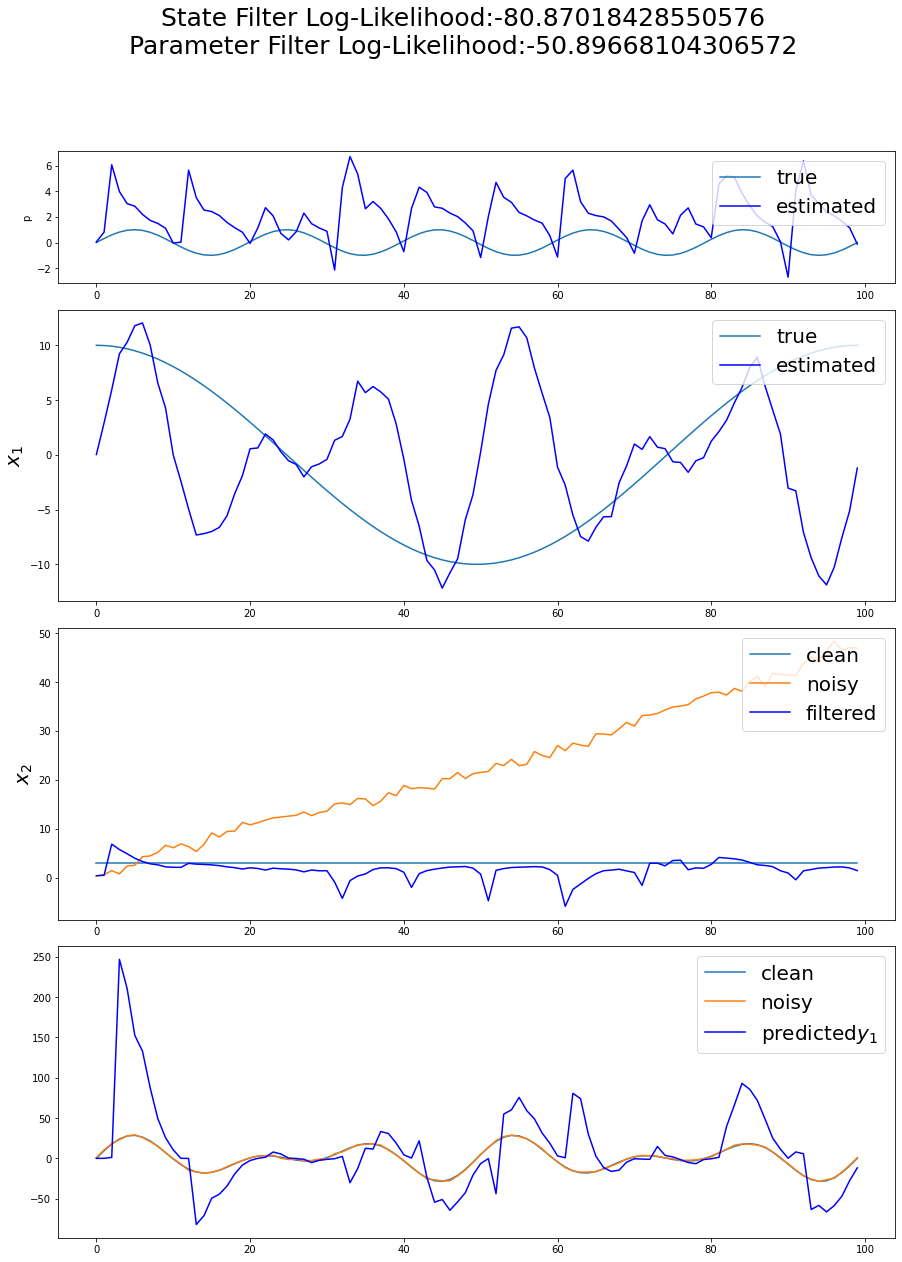

In [ ]:
fig=plt.figure(figsize=(15,20))
grid=gridspec.GridSpec(nrows=7,ncols=1,figure=fig)
fig.suptitle(
    'State Filter Log-Likelihood:{}\n'.format(np.mean(DUKF.sUKF.log_likelihoods)) + 
    'Parameter Filter Log-Likelihood:{}'.format(np.mean(DUKF.pUKF.log_likelihoods)),
    size=25
)
# estimated parameter
ax1=fig.add_subplot(grid[0,0])
ax1.plot(p,label='true')
ax1.plot(DUKF.pUKF.zs,label='estimated',color='b')
ax1.set_ylabel('p')
ax1.legend(loc='upper right',fontsize=20)
# estimated x1
ax2=fig.add_subplot(grid[1:3,0])
ax2.plot(x1_pure,label='true')
ax2.plot(DUKF.sUKF.zs[:,0],label='estimated',color='blue')
ax2.set_ylabel(r'$x_1$',size=20,weight='bold')
ax2.legend(loc='upper right',fontsize=20)
# filtered x2
ax3=fig.add_subplot(grid[3:5,0])
ax3.plot(x2_clean,label='clean')
ax3.plot(x2_noisy,label='noisy')
ax3.plot(DUKF.sUKF.zs[:,1],label='filtered',color='blue')
ax3.set_ylabel(r'$x_2$',size=20,weight='bold')
ax3.legend(loc='upper right',fontsize=20)
# observation predictions
ax4=fig.add_subplot(grid[5:7,0])
ax4.plot(y_clean,label='clean')
ax4.plot(y_noisy,label='noisy')
ax4.plot(DUKF.sUKF.xps[:,0],label='predicted'+r'$y_1$',color='b')
ax4.legend(loc='upper right',fontsize=20)

In [247]:
# state filter inference
def Q_inference(x,*args):
    ''' 
    A cholesky decomposition inspired inference.
    Parameters
    ----------
    *others :   tuple
        attr,pos_x,pos_y,...
    '''
    DUKF,data,scale,L0,*others = args
    attr = others.pop(0)
    if L0.shape[0] == 1:
        L0[0,0] == x
    else:
        L0[others[0],others[1]] = x
    KF = getattr(DUKF,attr); KF.Q = L0 @ L0.T; setattr(DUKF,attr,KF)
    # sanitycheck
    if not np.allclose(KF.Q, L0 @ L0.T):
        raise
    #DUKF.reparameterization(data[0,:])
    DUKF.main(data)
    KF = getattr(DUKF,attr); llk = np.sum(getattr(KF,'log_likelihoods'))/scale
    return -np.copy(llk)
    
import itertools
from scipy.optimize import minimize
method = 'Nelder-Mead'

s_results = {}
L0 = np.eye(2)
start = 0.5
for i,j in itertools.product(range(2),range(2)):
    if i < j:
        continue
    print('[{},{}] element being optimized.'.format(i,j),flush=True)
    result = minimize(
        fun = Q_inference,
        args = (DUKF,obs_noisy,100,L0,'sUKF',i,j),
        x0 = start,
        method = method,
        options = {'disp':True}
    )
    s_results['{},{}'.format(i,j)] = result
    L0[i,j] = start = result.x
sQ_updated = L0 @ L0.T
print(sQ_updated)

DUKF.sUKF.Q = sQ_updated

L0 = np.eye(1)
p_result = minimize(
    fun = Q_inference,
    args = (DUKF,obs_noisy,10,L0,'pUKF',i,j),
    x0 = 0.5,
    method = method,
    options = {'disp':True}   
)
pQ_updated = p_result.x**2
print(pQ_updated)

DUKF.pUKF.Q = pQ_updated

[0,0] element being optimized.
[1,0] element being optimized.
[1,1] element being optimized.
[[1.55625625e+02 6.07912598e-01]
 [6.07912598e-01 1.14042979e-02]]
[0.25]
